## Preamble

Run these if notebook is in a new environment, otherwise just skip to `Import modules`

1. partisipp + konjugert verb: kan vi se mønstre i hva som kan stå som konjugert verb?  Jeg ha noen vage resultater - at det er større variasjon i hva som opptrer i det konjugert elementet i oversatt tekst - men jeg er ikke sikker.

1. Har vi eksempler fra NB-korpusene på bli+partisipp, hvor partisippet ikke er et av de vanlige posisjonsverbene (jf ble lesende/ble drikkende  vs ble sittende og lese/drikke) - altså hele variasjonsbredden i denne strukturen.
1. - oppfølgingsspørsmål etter b) er det forskjell i variasjonsbredden i original vs oversatt norsk?

1. kunne tenkt meg å se hvilke partisipper som opptrer med 'fant ham/henne/dem + partisipp - tilsvarende 'så ham/henne/dem/deg + partisipp) (objektspredikativer) (Typisk: jeg fant ham + posisjonsverb (fant ham liggende/stående/sittende i grøfta - men ikke typisk:  fant ham gråtende/drikkende/etc

1. Partisipper i begynnelsen av setninger (frie predikativer):  Sittende med hodet i hendene fikk han endelig en ide....../Sittende på trappen med boken foran seg lignet han en filosof  - hvilke andre verb opptrer i slike partisipper?


#### Boot cell

Skip if `module_update.py` is in same folder as notebook, next cell downloads this file which in turn will download other files.

In [36]:
import dhlab.module_update as mu

In [37]:
from dhlab.module_update import update, css

In [38]:
css()

In [39]:
update('collocations')

Updated file `C:\Users\larsj\Documents\GitHub\Oversettelse\collocations.py`

In [40]:
from collocations import dist_coll_urn

In [41]:
from collections import Counter

# Import modules

Aktiver cellen nedenfor for å få alt til å virke.

In [42]:
import dhlab.nbtext as nb
from IPython.display import HTML
import requests
from bs4 import BeautifulSoup
import pandas as pd

def mods_digibok(urn, kind='marcxml'):
    """find information about serial number urn (or full urn) for books using NB API. 
    Parameter 'kind' is one of mods, marcxml or dublincore """
    
    if not str(urn).startswith('URN'):
        urnstr = "URN:NBN:no-nb_digibok_{urn}".format(urn=urn)
    r = requests.get("https://api.nb.no:443/catalog/v1/metadata/{ident}/{kind}".format(ident=urnstr, kind=kind))
    return r.text

def translator(urn):
    """Finds the translator for a book"""
    item = BeautifulSoup(mods_digibok(urn, kind='mods'), 'lxml')
    trans = []
    navn = item.find_all('name', {'type':'personal'})
    for i in navn:

        try:
            if i.roleterm.text == 'trl':
                trans.append(i.namepart.text)
        except:
            'nn'
    return ';'.join(trans)
    

In [43]:
def categorize(list_of_words):
    proprium = [x for x in list_of_words if x[0].upper() == x[0]]
    other = [x for x in list_of_words if not x in proprium]

    return {'propr':proprium,
           'other': other }

def select_form(w):
    fs = [x.split()[0] for x in nb.word_form(w)]
    if 'prep' in fs:
        res = 'prep'
    if 'verb' in fs:
        res = 'verb'
    elif 'subst' in fs:
        res = 'subst'
    elif len(fs) > 0:
        res = fs[0]
    else:
        res = 'unknown'
    return res

def sort_word_forms(words):
    res = {select_form(w):w for w in words}
    return res

def mdprint(forskjell, cutoff=5):
    categories = categorize(forskjell[forskjell > cutoff].dropna().index)
    forms = {w:select_form(w) for w in categories['other']}
    Grouping = {cat:[word for word in forms if forms[word] == cat] for cat in forms.values()}
    navn = "## Egennavn \n"
    navn += ', '.join(categories['propr'])
    pos = ""
    for cat in Grouping:
        pos += "## " + cat + "\n"
        pos += ', '.join(Grouping[cat]) + "\n"
    mu.printmd(navn)
    mu.printmd(pos)
    return

def velg_form(word):
    former = list({x.split()[0] for x in nb.word_form(word)})
    if 'prep' in former:
        res = 'prep'
    elif 'det' in former:
        res = 'det'
    elif 'pron' in former:
        res = 'pron'
    elif 'verb' in former:
        res = 'verb'
    elif 'subst' in former:
        res = 'subst'
    elif 'adj' in former:
        res = 'adj'
    else:
        try:
            res = former[0]
        except:
            res = 'ukjent'
    return res

def klassifikasjon(df, num = 60, column = 0, up=False):
    gruppering = list(map(lambda w: (w, velg_form(w)), df.sort_values(by=column, ascending=up).head(num).index))
    grupper = dict(gruppering)
    grupperinger = {cat:[w for w in grupper if grupper[w] == cat] for cat in grupper.values()}
    return nb.frame(grupperinger).transpose().fillna('')

In [44]:
def wordbags(words, urns):
    url = 'https://api.nb.no/ngram/wordbags'
    if isinstance(words, str):
        return
    if isinstance(words, list):
        words = {w:[w] for w in words}
    r = requests.post(url, json={'wordbags':words, 'urns':urns})
    return r.json()

In [45]:
def word_frequencies(words):
    url = 'https://api.nb.no/ngram/word_frequencies'
    if isinstance(words, str):
        words = words.split()
    r = requests.post(url, json={'words':words})
    return r.json()

In [46]:
from random import sample

import inspect
def urn_concordance(urns = None, word = None, size = 5, before = None, after = None, html=False):
    """ Find a concordance within a corpus as list of URNs. This is a wrapper for get_urnkonk """
    
    # exit if list of urns is empty
    if urns is None or word is None:
        return []
    
    # The URNs may be presented in different ways. 
    urns = nb.pure_urn(urns)
    
    # find values and feed everything to get_urnkonk
    frame = inspect.currentframe()
    args, _, _, values = inspect.getargvalues(frame)
    query = {i:values[i] for i in args if values[i] != None and i != 'word'}
    return nb.get_urnkonk(word, query, html=html)

In [47]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [48]:
nb.word_paradigm('spisende')

[['adj', ['spisende', 'spist', 'spiste']],
 ['verb', ['spis', 'spise', 'spiser', 'spises', 'spist', 'spiste']]]

In [49]:
th_props = [
  ('font-size', '18px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7ffff')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '18px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]


## Build corpus

A corpus definition is a set of URNs. Those can be obtained in various ways and stored as text or in MS-Word file.


### Define using metadata 

Lag korpus manuelt, fra excel eller andre kilder. Bare lim inn definisjonen mellom de triple """ """ under

In [50]:
korpus = pd.read_csv('korpus_urns_1980.csv', index_col = 0)

In [51]:
korpus_nob = pd.read_csv('korpus_urns_nob_1980', index_col = 0)

In [52]:
korpus_nob

urn                     author  \
0    2011041308067               Omre, Arthur   
1    2013043007014                        NaN   
2    2015082448047             Roestad, Bente   
3    2013042206017              Wilsberg, Jan   
4    2012112306021            Kloster, Gunvor   
5    2012112305061           Stokke, Bernhard   
6    2013120205014        Lillegaard, Leif B.   
7    2006111001010           Sandsdalen, Guro   
8    2013092407034               Midtbø, Tore   
9    2015021808385              Bjerke, André   
10   2010101220012          Cartland, Barbara   
11   2013102407318                Dalby, Gene   
12   2013061308240               Lyngås, Arne   
13   2009051104114             Halstvedt, Tor   
14   2006110700068             Larsen, Petter   
15   2013112606039                        NaN   
16   2015111907538                        NaN   
17   2012062706055                Dalby, Gene   
18   2012092606080                 Manus, Max   
19   2012092506009            Rud, Nils Johan   
20   2013040807050              Skram, Amalie   
21   2012121007133                  Ege, John   
22   2012062106073                 Moen, John   
23   2014013106084               Arnesen, Gro   
24   2011070406046  Michaelsen, Aslaug Groven   
25   2012092108088               Saus, Anders   
26   2012092106012           Stryken, Øystein   
27   2014100608077           Norland, Andreas   
28   2012121105039               Bronken, Per   
29   2014062307003             Ulstad, Gunnar   
..             ...                        ...   
270  2012011908119                        NaN   
271  2012121105109               Flock, Willy   
272  2007072600026             Hestenes, Arne   
273  2009051200015               Prøysen, Alf   
274  2012120705030         Johansen, Margaret   
275  2013061708151           Furuhatt, Trygve   
276  2013042305078           Lid, Dagny Tande   
277  2013061408162             Messel, Gunnar   
278  2012031908115    Hagen, Ingeborg Refling   
279  2012080808236                        NaN   
280  2012092108132            Pettersen, Knut   
281  2007072300031           Thams, Elisabeth   
282  2007080104051                        NaN   
283  2007092401081              Bloch, Robert   
284  2014072206091            Osmundsen, Mari   
285  2015041408079            Halle, Barthold   
286  2012120505056             Kullerud, Erik   
287  2013061108093             Messel, Gunnar   
288  2014030707088      Gulbransen, Reidar I.   
289  2009071001058               Ringen, Tone   
290  2007080200110           Lier, Svein Rolf   
291  2013040807065                        NaN   
292  2014071007101               Hagen, Inger   
293  2011060706052                        NaN   
294  2012100106171         Tønseth, Jan Jakob   
295  2016112948508             Elvestad, Sven   
296  2016040508077                        NaN   
297  2010110320014           Stenersen, Helge   
298  2007070904079   Christensen, Lars Saabye   
299  2013061408149          Otgard, Ragnar W.   

                                                 title  year  
0                                             Smuglere  1971  
1                                  - som det var i går  1974  
2                                 Blekkulf og Armianne  1990  
3                                         Sort oktober  1974  
4                                        Karens bilder  1979  
5                                     ensomme vaktpost  1978  
6                                          Fangeskipet  1974  
7                                           Saras rike  1977  
8                                 Fenomenet "Flåklypa"  1979  
9                                       Fremmede toner  1978  
10                         Drømmen som ble virkelighet  1990  
11                                           Neon/furu  1983  
12                                        Sildrebekken  1979  
13                                                Elva  1990  
14                             

# Henter bøkene med ord

Her defineres korpuset som en liste over bøker, med informasjon om oversettere. Er korpuset stort (flere hundre) vil det ta noen minutter å hente alle oversetterne, så det kan være lurt å kutte ned størrelsen litt. Inntil vi får på plass en rask måte å gjøre det på, får det her duge. Det er bare å smøre seg med tålmodighet.

## Search corpus for concordances

In [53]:
from random import sample

In [54]:
nb.urn_concordance(word='leende', urns= sample(nb.pure_urn(korpus), 50))

# Definer teksten

Lager mindre versjon av TEXT og TEXT_NOB for Github

In [55]:
TEXT = pd.read_csv('korpus_file_f5_1980.csv', index_col = 0)
TEXT_NOB = pd.read_csv('korpus_file_nob_f5_1980.csv', index_col = 0)

#### convertet to md
import pandas as pd
with open ('korpus_file.csv','r', encoding="utf-8") as f:
    text = pd.read_csv(f)

In [56]:
TEXT.sort_values(by=TEXT.columns[0], ascending=False)[:10]

2013031206018  2013040507021  2011012105050  2015082548139  \
,           1717.0         3488.0          556.0         4515.0   
.           1713.0         9025.0          914.0         8095.0   
«           1000.0           24.0          655.0          200.0   
»            971.0           23.0          634.0          183.0   
det          829.0         2265.0          242.0         1925.0   
og           788.0         2863.0          283.0         2822.0   
er           584.0         1181.0          254.0         1319.0   
å            507.0         1718.0          152.0         1003.0   
som          432.0         1140.0           82.0         1131.0   
en           415.0         1351.0          155.0         1484.0   

     2012071806015  2012022908075  2016030907022  2012062806124  \
,             46.0         3314.0         2644.0         6094.0   
.             61.0         5714.0         3384.0         7673.0   
«              1.0         1325.0           73.0         1745.0   
»              6.0         1380.0           72.0         1720.0   
det            9.0         1552.0         1237.0         2531.0   
og            16.0         1646.0         1709.0         4119.0   
er             7.0          433.0          518.0         1510.0   
å              2.0         1162.0          844.0         1571.0   
som            4.0         1234.0          537.0         1674.0   
en             4.0         1174.0          715.0         2014.0   

     2009092900105  2013012907209  ...  2015072108291  2012012008059  \
,           1519.0         3022.0  ...         4557.0           77.0   
.           2577.0         4247.0  ...         4059.0          241.0   
«           1402.0            7.0  ...         1277.0            NaN   
»           1373.0            7.0  ...         1262.0            NaN   
det          530.0          838.0  ...         1518.0           33.0   
og           747.0         1633.0  ...         2508.0           47.0   
er           399.0          385.0  ...          759.0           12.0   
å            624.0          717.0  ...          992.0           17.0   
som          277.0          678.0  ...         1028.0           16.0   
en           320.0          835.0  ...         1168.0            NaN   

     2011110208183  2010101208095  2011022320087  2014032406004  \
,             12.0           90.0         1744.0         3826.0   
.             30.0          247.0         2640.0         4929.0   
«              2.0           46.0            4.0          122.0   
»              1.0           56.0           21.0          119.0   
det            2.0           40.0          615.0         1390.0   
og             3.0           73.0          690.0         2268.0   
er             4.0            5.0          419.0          529.0   
å              NaN           28.0          415.0         1252.0   
som            2.0           28.0          281.0         1094.0   
en             4.0           31.0          456.0         1330.0   

     2015102308102  2016062748040  2014103008108  2013060708127  
,           6422.0         3996.0         3368.0         4342.0  
.           7894.0         5459.0         2423.0         5566.0  
«            184.0         2124.0           55.0         1740.0  
»            170.0         2089.0           54.0         1718.0  
det         1531.0         1908.0          742.0         1957.0  
og          5462.0         3180.0         1436.0         2435.0  
er           738.0         1056.0          441.0         1094.0  
å           1684.0         1222.0          870.0         1464.0  
som         2150.0         1189.0          967.0          916.0  
en          1609.0         1205.0          787.0         1144.0  

[10 rows x 300 columns]

### Starter med listen over mulige partisipper

In [57]:
TEXT.index = TEXT.index.map(str)

In [58]:
poss_part = list ({x for x in TEXT.index if x.endswith('ende')})

In [59]:
TEXT.index

Index([',', '.', '«', '»', 'det', 'og', 'er', 'å', 'som', 'en',
       ...
       '„', '•', '€', '™', '□', '►', '▼', '★', '♦', '✓'],
      dtype='object', length=73246)

### Henter ut de 100 mest frekvente

In [60]:
N = 200
test_words = list(TEXT.loc[TEXT.index.str.contains(".*ende$")].sum(axis=1).sort_values(ascending=False)[:N].index)

In [61]:
variants = dict()
for w in test_words:
    variants[w] = nb.word_paradigm(w)

In [62]:
forms = dict()
for w in test_words:
    forms[w] = nb.word_form(w)

In [63]:
var = nb.frame(variants)

In [64]:
var.loc[['levende', 'vende']]

0  \
levende  [adj, [levd, levde, levede, levende, levet, le...   
vende                     [adj, [vendende, vendt, vendte]]   

                                                         1  \
levende  [verb, [lev, levd, levde, leve, lever, leves, ...   
vende      [subs, [venda, vende, venden, vendene, vender]]   

                                                         2     3  
levende                                               None  None  
vende    [verb, [vend, vende, vender, vendes, vendt, ve...  None

## Velg former

Plukk ut partisippformene, dersom formen opptrer både som adjektiv og som verb, ellers ut. Nedenfor plukkes ut de alternative verbformene som kan sammenlignes med partisippen.

Her benyttes en enkelt heuristikk. Partisippformen må være oppført både som et adjektiv og et verb, i tillegg må ikke formen selv være blandt verbene.

In [178]:
nb.word_form('løpende')

['adj <pres-part> <intrans1> <trans1> <adv3> normert',
 'adj pos be ent normert',
 'adj pos fl normert',
 'adj pos m/f ub ent normert',
 'adj pos nøyt ub ent normert']

In [65]:
participles = dict()
for w in variants:
    # finn POS for alle variantene
    kinds = [x[0] for x in variants[w]]
    
    # sjekk at både adj og verb er blant dem
    if 'adj' and 'verb' in kinds:
        
        # Ta ut de som har formen blant verbene (partisippet er ikke verd i NO)
        F = [k[1] for k in variants[w] if k[0] == 'verb' and not w in k[1] ]
        if F != []:
            participles[w] = F

## Se på resultatet

In [66]:
participles

{'stående': [['sto', 'stod', 'stå', 'ståes', 'står', 'stås', 'stått']],
 'rasende': [['ras', 'rasa', 'rase', 'raser', 'rases', 'rast', 'raste']],
 'sittende': [['satt', 'sitt', 'sitte', 'sitter', 'sittes', 'sittet']],
 'levende': [['lev', 'levd', 'levde', 'leve', 'lever', 'leves', 'levet']],
 'liggende': [['ligg', 'ligge', 'ligger', 'ligges', 'ligget', 'lå', 'låg']],
 'strålende': [['strål', 'stråle', 'stråler', 'stråles', 'strålt', 'strålte']],
 'skinnende': [['skein',
   'skinn',
   'skinne',
   'skinner',
   'skinnes',
   'skint',
   'skinte']],
 'smilende': [['smil', 'smile', 'smiler', 'smiles', 'smilt', 'smilte']],
 'skjelvende': [['skalv',
   'skjelv',
   'skjelve',
   'skjelver',
   'skjelves',
   'skjelvet']],
 'spennende': [['spenn', 'spenne', 'spenner', 'spennes', 'spent', 'spente']],
 'utseende': [['utse', 'utsees', 'utser', 'utses', 'utsett', 'utså', 'utsåg']],
 'hengende': [['heng',
   'henge',
   'henger',
   'henges',
   'hengt',
   'hengte',
   'hang']],
 'gående': [['g

Nå lager vi en ny statistikk der alle ordene telles opp fra datarammen for sammenligning

In [67]:
counts = dict()
for w in participles:
    counts[w] = max(1, TEXT.loc[list(set(participles[w][0]) & set(TEXT.index))].sum(axis=1).sum())

In [68]:
counts_nob = dict()
for w in participles:
    counts_nob[w] = max(1, TEXT_NOB.loc[list(set(participles[w][0]) & set(TEXT_NOB.index))].sum(axis=1).sum())

In [69]:
for x in Counter(counts_nob).most_common()[:10]:
    print(x[0], x[1])

værende 397236.0
farende 126584.0
kommende 61380.0
gående 53923.0
vitende 30871.0
sittende 29748.0
stående 28259.0
liggende 17147.0
troende 14285.0
spørrende 11392.0


In [70]:
for x in Counter(counts).most_common()[:10]:
    print(x[0], x[1])

værende 606753.0
farende 191928.0
kommende 99214.0
gående 81579.0
vitende 53558.0
sittende 34494.0
stående 31682.0
troende 30292.0
spørrende 22886.0
liggende 18761.0


# Legg til opptellinger for partisippene

In [71]:
count_frame = {x: {'verb_paradigm': counts[x], 'participle': TEXT.loc[x].sum()} for x in counts}

In [72]:
count_frame_nob = {x: {'verb_paradigm': counts_nob[x], 'participle': TEXT_NOB.loc[x].sum()} for x in counts_nob}

In [73]:
count_frame

{'stående': {'verb_paradigm': 31682.0, 'participle': 3063.0},
 'rasende': {'verb_paradigm': 1237.0, 'participle': 1973.0},
 'sittende': {'verb_paradigm': 34494.0, 'participle': 1823.0},
 'levende': {'verb_paradigm': 5363.0, 'participle': 1599.0},
 'liggende': {'verb_paradigm': 18761.0, 'participle': 1259.0},
 'strålende': {'verb_paradigm': 576.0, 'participle': 1080.0},
 'skinnende': {'verb_paradigm': 1607.0, 'participle': 839.0},
 'smilende': {'verb_paradigm': 12655.0, 'participle': 809.0},
 'skjelvende': {'verb_paradigm': 2257.0, 'participle': 804.0},
 'spennende': {'verb_paradigm': 1320.0, 'participle': 799.0},
 'utseende': {'verb_paradigm': 36.0, 'participle': 751.0},
 'hengende': {'verb_paradigm': 4935.0, 'participle': 707.0},
 'gående': {'verb_paradigm': 81579.0, 'participle': 693.0},
 'truende': {'verb_paradigm': 1365.0, 'participle': 608.0},
 'skremmende': {'verb_paradigm': 2021.0, 'participle': 607.0},
 'løpende': {'verb_paradigm': 9133.0, 'participle': 600.0},
 'passende': {'v

In [74]:
COUNTS = nb.frame(count_frame)

In [75]:
COUNTS.sort_values(by='participle', ascending=False).head(10).participle

stående       3063.0
rasende       1973.0
sittende      1823.0
levende       1599.0
liggende      1259.0
strålende     1080.0
skinnende      839.0
smilende       809.0
skjelvende     804.0
spennende      799.0
Name: participle, dtype: float64

In [76]:
COUNTS_NOB = nb.frame(count_frame_nob)

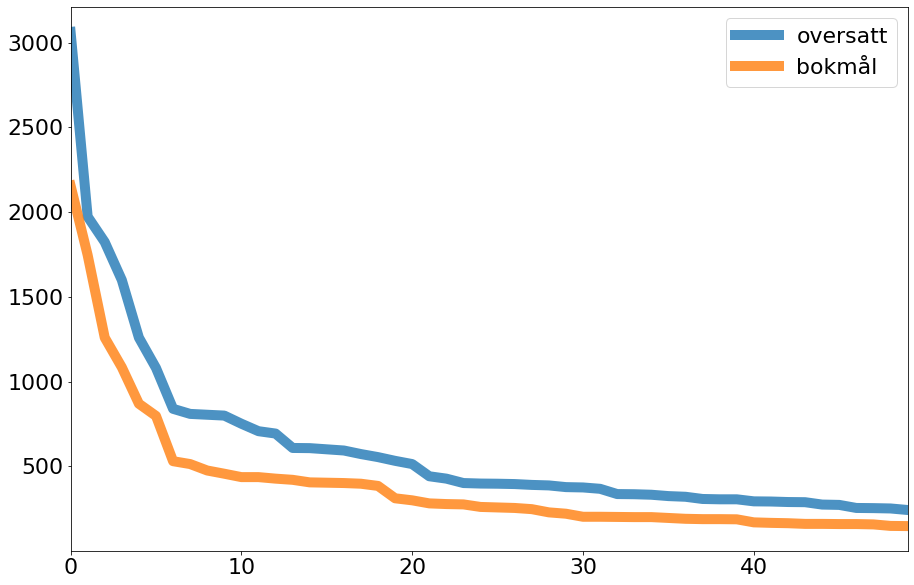

In [77]:
pd.concat([
    nb.frame(COUNTS.sort_values(by='participle', ascending=False).head(50).participle.values, 'oversatt'),
    nb.frame(COUNTS_NOB.sort_values(by='participle', ascending=False).head(50).participle.values,'bokmål')
], sort=False).plot(lw=10, alpha = .8, figsize=(15,10))

In [78]:
len([x for x in COUNTS.sort_values(by='participle', ascending=False)[:50].index if x in COUNTS_NOB.sort_values(by='participle', ascending=False)[:50].index])

38

In [79]:
TEXT_NOB.loc[[x for x in COUNTS.index if x not in COUNTS_NOB.index]].sum(axis=1)

Series([], dtype: float64)

In [80]:
nb.urn_concordance(word='følgende', urns=korpus_nob)

In [81]:
TOT = nb.totals(50000)

In [82]:
TOT = nb.frame(TOT)

Legg til en kolonne med ratioen melllom de to første. 

In [83]:
COUNTS['ratio'] = COUNTS['participle']/(COUNTS['participle']+COUNTS['verb_paradigm'])

In [84]:
COUNTS_NOB['ratio'] = COUNTS_NOB['participle']/(COUNTS_NOB['participle']+COUNTS_NOB['verb_paradigm'])

# Sortér på ratio

Her ser vi klart at det kanskje ikke er ekte partisipper på topp, mer typiske ord i partisippform.

De mest interessante ordene (tror jeg) er på bunnen her, som 'smilende', 'løpende', 'liggende', 'spørrende'. Og den ratioen kan sammenlignes med norsk sett.

In [85]:
def check_frames(column, number):
    return len([x for x in COUNTS.sort_values(by=column, ascending=False)[:number].index 
                if x in COUNTS_NOB.sort_values(by=column, ascending=False)[:number].index])

In [86]:
check_frames('participle', 50)

38

In [87]:
COUNTS.sort_values(by='ratio', ascending=False)

verb_paradigm  participle     ratio
fremtredende                1.0       127.0  0.992188
glimrende                  13.0       288.0  0.956811
gjennomtrengende            9.0       195.0  0.955882
utseende                   36.0       751.0  0.954257
sjarmerende                49.0       375.0  0.884434
misbilligende              19.0       144.0  0.883436
triumferende               69.0       398.0  0.852248
unnvikende                 23.0       122.0  0.841379
vedkommende                86.0       441.0  0.836812
aldrende                   23.0       114.0  0.832117
skingrende                 69.0       289.0  0.807263
fortryllende               35.0       141.0  0.801136
foruroligende              41.0       164.0  0.800000
tilsvarende                50.0       188.0  0.789916
skurrende                  45.0       136.0  0.751381
frastøtende                40.0       120.0  0.750000
forestående                50.0       145.0  0.743590
fremstående                50.0       137.0  0.732620
nedlatende                 73.0       146.0  0.666667
strålende                 576.0      1080.0  0.652174
utelukkende               188.0       336.0  0.641221
rasende                  1237.0      1973.0  0.614642
utfordrende               182.0       254.0  0.582569
blendende                 183.0       232.0  0.559036
glinsende                 126.0       159.0  0.557895
beroligende               466.0       554.0  0.543137
grunnleggende             107.0       126.0  0.540773
omgående                  245.0       272.0  0.526112
tiltrekkende              378.0       401.0  0.514763
anerkjennende             139.0       143.0  0.507092
...                         ...         ...       ...
trettende                2940.0       142.0  0.046074
skrikende                4568.0       214.0  0.044751
rørende                  3573.0       147.0  0.039516
svingende                3333.0       137.0  0.039481
gråtende                 3562.0       138.0  0.037297
drivende                 5140.0       198.0  0.037093
følgende                10603.0       395.0  0.035916
døende                   8881.0       324.0  0.035198
lysende                 10810.0       367.0  0.032835
gjeldende                4245.0       133.0  0.030379
lovende                  4964.0       151.0  0.029521
leende                   6542.0       199.0  0.029521
stikkende                6894.0       175.0  0.024756
elskende                 4995.0       118.0  0.023078
bedende                  5990.0       141.0  0.022998
boende                   5511.0       126.0  0.022352
spørrende               22886.0       513.0  0.021924
drepende                 5667.0       117.0  0.020228
kjørende                 8698.0       172.0  0.019391
tiende                   5912.0       116.0  0.019244
stirrende                9268.0       176.0  0.018636
prøvende                10200.0       154.0  0.014873
reisende                12801.0       140.0  0.010818
gående                  81579.0       693.0  0.008423
ventende                16077.0       129.0  0.007960
troende                 30292.0       127.0  0.004175
vitende                 53558.0       174.0  0.003238
kommende                99214.0       149.0  0.001500
farende                191928.0       189.0  0.000984
værende                606753.0       157.0  0.000259

[161 rows x 3 columns]

In [88]:
COUNTS_NOB.sort_values(by='ratio', ascending=False)[:20]

verb_paradigm  participle     ratio
misbilligende               1.0        36.0  0.972973
utseende                   14.0       254.0  0.947761
glimrende                  18.0       106.0  0.854839
sjarmerende                14.0        81.0  0.852632
unnvikende                 13.0        66.0  0.835443
frastøtende                16.0        61.0  0.792208
vedkommende                76.0       275.0  0.783476
foruroligende              18.0        63.0  0.777778
nedlatende                 22.0        75.0  0.773196
skingrende                 52.0       159.0  0.753555
fortryllende               19.0        58.0  0.753247
tilsvarende                67.0       200.0  0.749064
gjennomtrengende           35.0        95.0  0.730769
aldrende                   38.0        99.0  0.722628
triumferende               63.0       164.0  0.722467
fremtredende               42.0        83.0  0.664000
forestående                46.0        81.0  0.637795
glinsende                  85.0       140.0  0.622222
utelukkende               126.0       202.0  0.615854
utfordrende               103.0       148.0  0.589641

In [89]:
', '.join([x for x in COUNTS_NOB.sort_values(by='ratio', ascending=False)[:20].index])

'misbilligende, utseende, glimrende, sjarmerende, unnvikende, frastøtende, vedkommende, foruroligende, nedlatende, skingrende, fortryllende, tilsvarende, gjennomtrengende, aldrende, triumferende, fremtredende, forestående, glinsende, utelukkende, utfordrende'

In [90]:
hi_bm = [x for x in COUNTS_NOB.sort_values(by='ratio', ascending=False)[:20].index]
hi_ov = [x for x in COUNTS.sort_values(by='ratio', ascending=False)[:20].index]
lo_ov = [x for x in COUNTS.sort_values(by='ratio', ascending=True)[:20].index]
lo_bm = [x for x in COUNTS_NOB.sort_values(by='ratio', ascending=True)[:20].index]

In [91]:
hi_ov

['fremtredende',
 'glimrende',
 'gjennomtrengende',
 'utseende',
 'sjarmerende',
 'misbilligende',
 'triumferende',
 'unnvikende',
 'vedkommende',
 'aldrende',
 'skingrende',
 'fortryllende',
 'foruroligende',
 'tilsvarende',
 'skurrende',
 'frastøtende',
 'forestående',
 'fremstående',
 'nedlatende',
 'strålende']

# Sammenligner ratio for oversatt mot NOB

In [92]:
COMP = COUNTS['ratio']/COUNTS_NOB['ratio']

In [93]:
HTML(nb.frame(COMP.sort_values(ascending=False)).to_html())

In [94]:
COUNTS['participle'].loc['glimrende']

288.0

In [95]:
COUNTS_NOB['participle'].loc['verkende']

68.0

In [96]:
all_participles = list(set(COUNTS.participle.index) | set(COUNTS_NOB.participle.index))

# Make concordances of all from both corpora

## Aggregates of texts

In [97]:
TEXT_NOB.sum(axis=1).sum()

15195470.0

In [98]:
TEXT.sum(axis=1).sum()

22656570.0

In [99]:
verb_paradigme = lambda x: [p for p in nb.word_paradigm(x) if p[0] == 'verb'][0][1:][0] + [x]
paradigme_streng = lambda x: ', '.join(verb_paradigme(x))

In [100]:
verb_paradigme('leende')

['le',
 'ledd',
 'ler',
 'les',
 'lo',
 'lea',
 'lee',
 'leer',
 'lees',
 'leet',
 'leende']

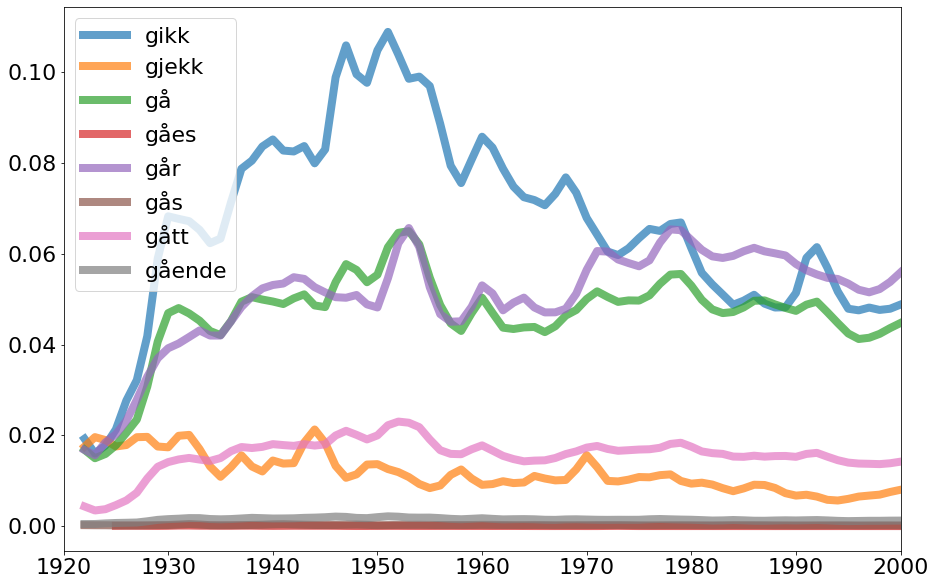

In [101]:
nb.nb_ngram(paradigme_streng('gående'), years=(1920, 2000)).plot(lw=8, alpha=0.7, figsize=(15, 10))

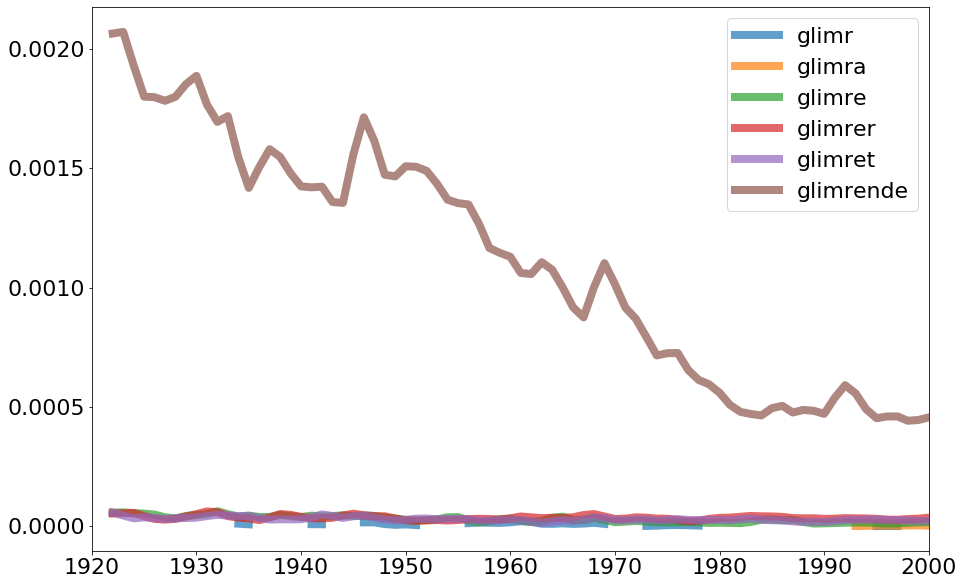

In [102]:
nb.nb_ngram(paradigme_streng('glimrende'), years=(1920, 2000)).plot(lw=8, alpha=0.7, figsize=(15, 10))

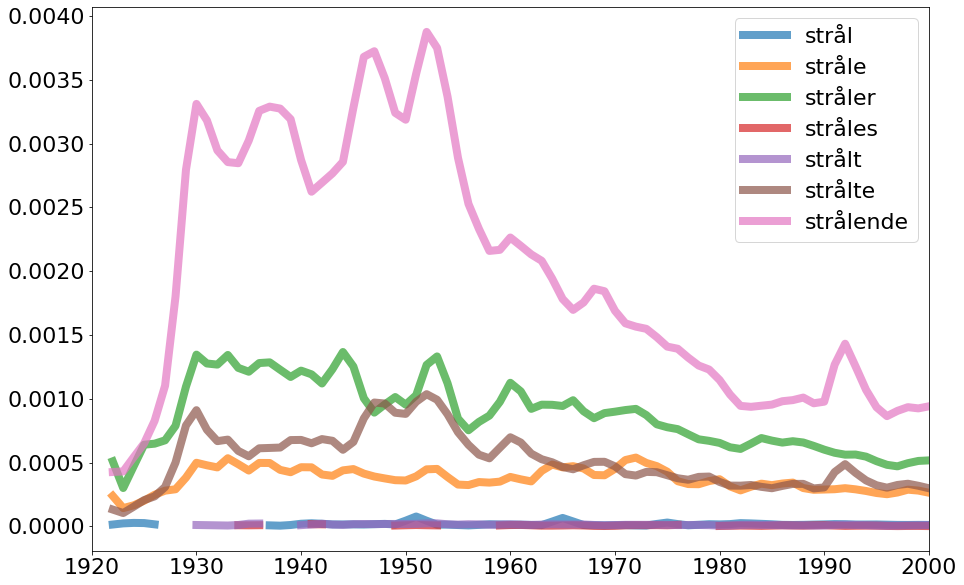

In [103]:
nb.nb_ngram(paradigme_streng('strålende'), years=(1920, 2000)).plot(lw=8, alpha=0.7, figsize=(15, 10))

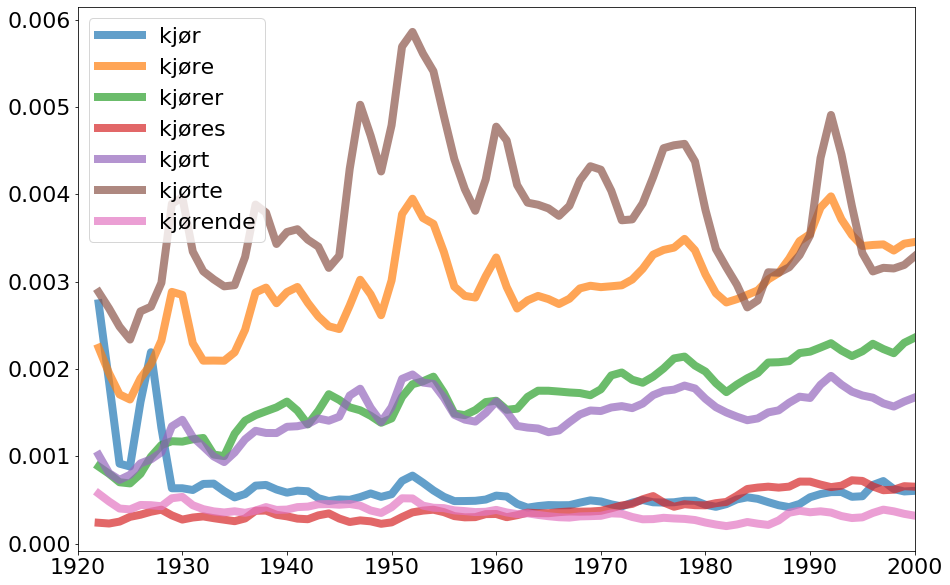

In [172]:
nb.nb_ngram(paradigme_streng('kjørende'), years=(1920, 2000)).plot(lw=8, alpha=0.7, figsize=(15, 10))

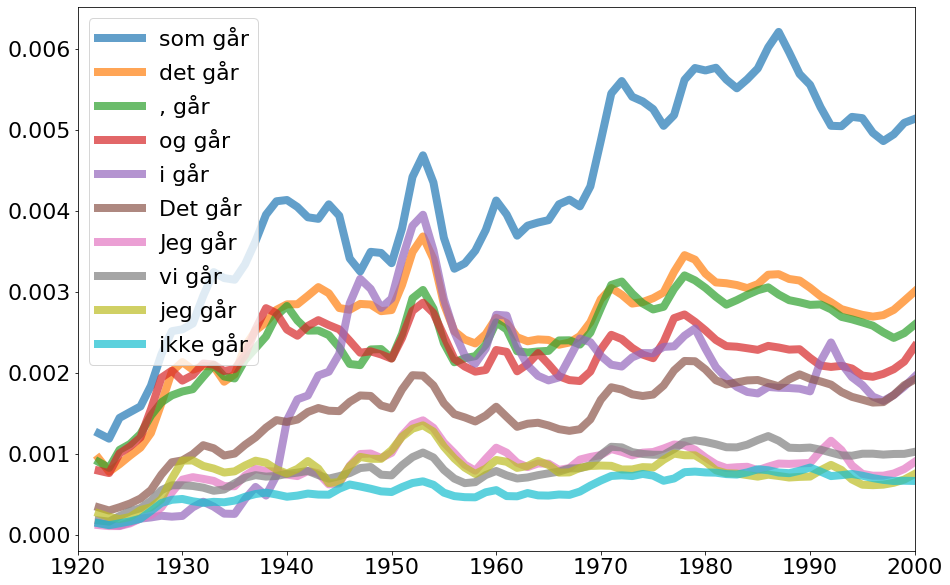

In [104]:
nb.nb_ngram('* går', years=(1920, 2000)).plot(lw=8, alpha=0.7, figsize=(15, 10))

In [105]:
punkt = nb.unigram('.', ddk="8%", trans='eng', period=(1945, 2000))

In [106]:
like = nb.unigram('likestilling', ddk="8%", trans='eng', period = (1945, 2000))

In [107]:
def relfrekvens(word, **kwarg):
    punkt = nb.unigram('.', **kwarg)
    wd = nb.unigram(word, **kwarg)
    return nb.frame(wd/punkt, word)

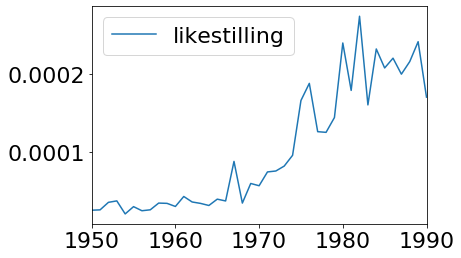

In [108]:
relfrekvens('likestilling',media='bok', period=(1950, 1990)).plot()

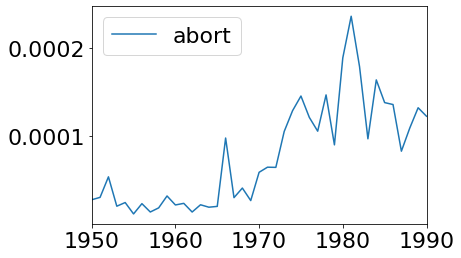

In [109]:
relfrekvens('abort',media='bok', period=(1950, 1990)).plot()

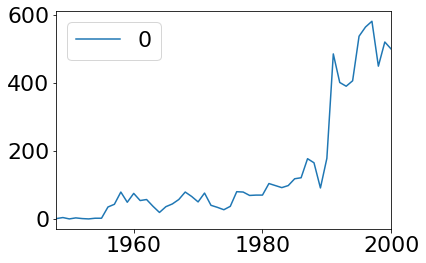

In [110]:
nb.unigram('verkende', ddk="8%", trans='eng', period=(1945, 2000)).plot()

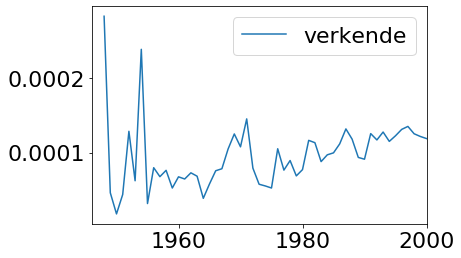

In [111]:
relfrekvens('verkende',ddk="8%", trans='eng', period=(1945, 2000)).plot()

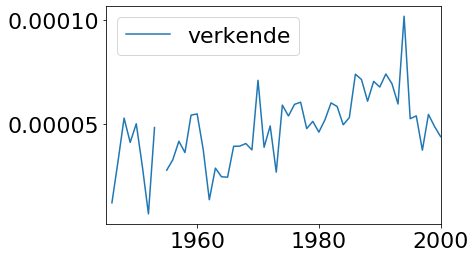

In [112]:
relfrekvens('verkende', ddk="8%", trans='', period=(1945, 2000)).plot()

In [113]:
counts_tot = dict()
for w in participles:
    counts_tot[w] = max(1, TOT.loc[list(set(participles[w][0]) & set(TOT.index))].sum(axis=1).sum())

In [114]:
counts_tot

{'stående': 19437983,
 'rasende': 635995,
 'sittende': 19514023,
 'levende': 5312408,
 'liggende': 14864068,
 'strålende': 323529,
 'skinnende': 864480,
 'smilende': 3740043,
 'skjelvende': 683719,
 'spennende': 751509,
 'utseende': 73206,
 'hengende': 2623103,
 'gående': 39842605,
 'truende': 2250953,
 'skremmende': 643472,
 'løpende': 4492046,
 'passende': 3018854,
 'lignende': 1124850,
 'beroligende': 161135,
 'brennende': 1559790,
 'spørrende': 7493284,
 'vedkommende': 67666,
 'flytende': 644943,
 'tiltrekkende': 202167,
 'triumferende': 1,
 'glitrende': 131025,
 'følgende': 8535735,
 'overraskende': 561859,
 'nølende': 385535,
 'imponerende': 200342,
 'sjarmerende': 1,
 'lysende': 5765415,
 'utelukkende': 329885,
 'oppmuntrende': 242364,
 'glødende': 214013,
 'døende': 4840940,
 'forbausende': 400348,
 'avgjørende': 1212211,
 'besøkende': 1711432,
 'forbløffende': 123009,
 'overbevisende': 674140,
 'overveldende': 91829,
 'skingrende': 1,
 'glimrende': 1,
 'overlevende': 539336,
 

In [115]:
count_frame_tot = {x: {'verb_paradigm': counts_tot[x], 'participle': TOT.loc[x].sum()} for x in counts_tot if x in TOT.index}

In [116]:
TOTCOUNT = nb.frame(count_frame_tot)

In [117]:
TOTCOUNT

verb_paradigm  participle
advarende                 336853       66111
aldrende                   59202       53012
anerkjennende             361350       46021
angående                  572794      267385
anklagende                289970       36067
anstrengende              247621       72006
avgjørende               1212211     1008752
bebreidende               122541       42515
bedende                  4314613       62088
beroligende               161135      171112
beskyttende               935404      101438
besøkende                1711432      124985
beundrende                310904       55098
bitende                  2679536       55127
blendende                  45274       67854
blomstrende               240663      102584
blussende                  47835       38124
boende                   4788236      149412
brennende                1559790      243684
brølende                  359925       30360
bydende                   495097       39578
bølgende                  428659       70373
bønnfallende               38809       28097
dampende                  231783       43486
dansende                 1756754       56382
dinglende                  46020       30994
dirrende                  152646       69947
drepende                 1955925       40639
drivende                 4946841      119152
dryppende                 168965       35657
...                          ...         ...
svingende                1183951       50676
svulmende                  37145       45314
tiende                   4128616      134819
tilfredsstillende         485378      507238
tilsvarende               429668     1682439
tiltalende                361018       90415
tiltrekkende              202167      109016
tordnende                  45958       22741
trettende                 710078       46913
triumferende                   1       96177
troende                 11323581      265522
truende                  2250953      272187
trykkende                2244371       72605
trøstende                 562073       51994
tvilende                 1672519       73501
undersøkende             1342556       40720
undrende                  591936       73672
unnskyldende              186425       53705
unnvikende                     1       38566
utelukkende               329885      389967
utfordrende               224945      143066
utseende                   73206      348198
vaklende                  151315       61035
vedkommende                67666     1744651
ventende                 5696101       60326
verkende                 1757228       35173
vitende                 20200355       78416
voksende                 2280580      202621
værende                456572224      191340
økende                   4266385      667351

[161 rows x 2 columns]

In [118]:
TOTCOUNT['ratio'] = TOTCOUNT['participle']/(TOTCOUNT['participle']+TOTCOUNT['verb_paradigm'])

In [119]:
TOTCOUNT.sort_values(by='ratio', ascending=False)

verb_paradigm  participle     ratio
glimrende                      1      185539  0.999995
sjarmerende                    1      103095  0.999990
triumferende                   1       96177  0.999990
skingrende                     1       70651  0.999986
gjennomtrengende               1       53225  0.999981
nedlatende                     1       51633  0.999981
foruroligende                  1       48308  0.999979
fortryllende                   1       40939  0.999976
unnvikende                     1       38566  0.999974
frastøtende                    1       36969  0.999973
misbilligende                  1       27242  0.999963
skurrende                      1       22798  0.999956
vedkommende                67666     1744651  0.962663
utseende                   73206      348198  0.826281
tilsvarende               429668     1682439  0.796569
fremtredende               62699      177705  0.739193
glinsende                  32526       81620  0.715049
grunnleggende             337763      815596  0.707148
overveldende               91829      155546  0.628786
blendende                  45274       67854  0.599798
forestående                61255       84677  0.580250
svulmende                  37145       45314  0.549534
utelukkende               329885      389967  0.541732
flagrende                  43466       48351  0.526602
strålende                 323529      346513  0.517151
beroligende               161135      171112  0.515014
tilfredsstillende         485378      507238  0.511011
fascinerende               64972       67227  0.508529
imponerende               200342      204546  0.505192
stinkende                  54910       55014  0.500473
...                          ...         ...       ...
gråtende                 1525995       59659  0.037624
lysende                  5765415      205146  0.034360
sittende                19514023      673395  0.033357
tiende                   4128616      134819  0.031622
trykkende                2244371       72605  0.031336
dansende                 1756754       56382  0.031096
boende                   4788236      149412  0.030260
undersøkende             1342556       40720  0.029437
stikkende                2465419       66512  0.026269
reisende                 7050128      185766  0.025673
døende                   4840940      126117  0.025391
kjørende                 2925304       75802  0.025258
drivende                 4946841      119152  0.023520
troende                 11323581      265522  0.022911
spørrende                7493284      166140  0.021691
stirrende                2031773       44874  0.021609
drepende                 1955925       40639  0.020354
bitende                  2679536       55127  0.020159
verkende                 1757228       35173  0.019623
elskende                 2220700       43687  0.019293
lovende                  6004705      103428  0.016933
bedende                  4314613       62088  0.014186
prøvende                 5113315       54768  0.010597
ventende                 5696101       60326  0.010480
leende                  11129835       99493  0.008860
gående                  39842605      296548  0.007388
kommende                50235401      326006  0.006448
vitende                 20200355       78416  0.003867
værende                456572224      191340  0.000419
farende                209473618       71677  0.000342

[161 rows x 3 columns]

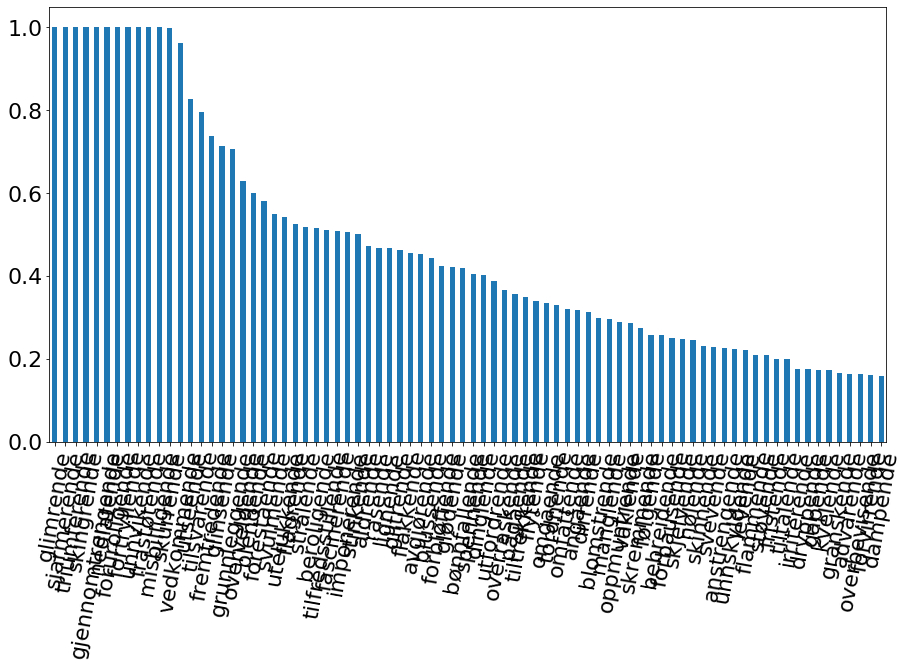

In [120]:
TOTCOUNT.sort_values(by='ratio', ascending=False)[:80]['ratio'].plot(kind='bar', figsize=(15, 8), rot=80)

In [121]:
relaterte = dict()
for w in TOTCOUNT.sort_values(by='ratio', ascending=False)[:50].index:
    try:
        relaterte[w] = nb.relaterte_ord(w)
    except:
        print('problem: ', w)

problem:  triumferende
problem:  skingrende
problem:  gjennomtrengende
problem:  nedlatende
problem:  misbilligende
problem:  skurrende
problem:  vedkommende
problem:  glinsende
problem:  grunnleggende
problem:  overveldende
problem:  utelukkende
problem:  glitrende
problem:  flakkende
problem:  blussende
problem:  forbløffende
problem:  bønnfallende
problem:  dinglende
problem:  flytende
problem:  omgående
problem:  tordnende


In [122]:
import dhlab.graph_networkx_louvain as gnl

In [123]:
for participle in relaterte:
    mu.printmd("## {p} \n {words}\n".format(p=participle, words = ", ".join(relaterte[participle])))

## glimrende 
 snø, sol, sne, glimrende, kuldegrader, vind, regn, fint, kulde, slaps, is, sludd, frost, skiføre, isdekke, glatt, vindstille, tåke, fleksibel, nydelig


## sjarmerende 
 sjarmerende, morsom, hyggelig, underholdende, blid, utadvendt, innholdsrik, lærerik, dyktig, grei, kjekk, tiltalende, koselig, vittig, interessant, søt, spennende, inspirerende, omgjengelig, hjelpsom


## foruroligende 
 kraft, energi, vilje, styrke, fart, spenst, foruroligende, tyngde, fylde, farlig, uoversiktlig, vanskelig, uforutsigbar


## fortryllende 
 fargerik, poetisk, dramatisk, humoristisk, vakker, fortryllende, festlig, fantasifull, flott, frodig, spennende, variert, mangfoldig, morsom, vittig, vakkert, varm, musikalsk, burlesk, realistisk


## unnvikende 
 forsiktig, unnvikende, nøktern, nølende, gradvis, avventende, hemmelig, svak, splittet, sterk, feig


## frastøtende 
 skremmende, tiltrekkende, fascinerende, farlig, spennende, plagsom, sjokkerende, übehagelig, mystisk, uhyggelig, tankevekkende, truende, trist, frastøtende, kaotiske, oppsiktsvekkende, interessant, fremmed, overraskende, eksotisk


## utseende 
 utseende, kvalitet, karakter, innhold, stil, størrelse, personlighet, smak, farge, sjarm, form, konsistens, omfang, soliditet, særpreg, væremåte, egenart, design, atmosfære, sunnhet


## tilsvarende 
 erfaring, kunnskap, praksis, kunnskaper, innsikt, rutine, utdannelse, kvalifikasjoner, kompetanse, relevant, fortrinnsvis, minimum, helst, allsidig, solid, tilsvarende, storhusholdning, servicehandel, ledererfaring, bakgrunn


## fremtredende 
 kjente, fremtredende, ukjente, kjære, trygge, regjeringsmedlemmer, parlamentarikere, stortingsrepresentanter


## blendende 
 rent, blendende, tørt, hvitt, pent, blankt, ryddig, friskt, fint, vakkert, klart, velspilte, gammel, ny, spennende, reflekser


## forestående 
 pågående, frekk, aggressive, uredd, aktiv, utholdende, aggressiv, energisk


## svulmende 
 freidig, frodig


## flagrende 
 lys, flagrende, luft, romslig, vann, vand, pen, lyd, løst


## strålende 
 sol, strålende, vind, sne, kuldegrader, regn, fint, vindstille, varmegrader, plussgrader, himmel, varig, minusgrader, solskinn, frisk, tåke, varme, sjø, utsikt, tropevarme


## beroligende 
 amfetamin, alkohol, beroligende, avslappende, tabletter, piller, narkotiske, hasj, stimulerende, smertestillende, styrkende, ecstasy, LSD, rohypnol, hasjisj, kokain, marihuana, ecstacy, heroin, metamfetamin


## tilfredsstillende 
 forsvarlig, rasjonelt, betryggende, effektiv, tilfredsstillende, rimelig, stabil, tidsmessig, hurtig, billig, økonomisk, riktig, hensiktsmessig, fornuftig, effektivt, sikker, skånsom, målrettet, miljøvennlig, langsiktig


## fascinerende 
 utfordrende, inspirerende, spennende, interessant, lærerike, utviklende, lærerik, krevende, engasjerende, givende, lærerikt, fengslende, underholdende, fascinerende, variert, morsomt, interessante, varierende, morsom, gripende


## imponerende 
 spennende, inspirerende, skremmende, imponerende, rørende, morsomt, morsom, fengende, variert, utfordrende, engasjerende, utviklende, krevende, lærerik, lærerikt, givende, dramatisk, vakker, flott, storslått


## stinkende 
 forurensende, støyende


## aldrende 
 slitne, syke, ensom, aldrende, trøytte, kalde, sultne, våte, frustrerte, svette, trøtte, trette, utbrente, funksjonshemmede, fattige, gamle, sårede, eldre, friske, svake


## rasende 
 oppgitt, skuffet, fortvilet, forbannet, lei, frustrerte, sint, opprørt, sjokkert, frustrert, irritert, sinte, rasende, provosert, deprimert, såret, desillusjonert, forbanna, føler, fortvilt


## lignende 
 konserter, messer, lignende, arrangementer, utstillinger, festivaler, seminarer, workshops, andre, turneer, teater, kunstutstillinger, plateinnspillinger, foredrag, forestillinger, teaterforestillinger, markeder, konferanser, kongresser, stands


## avgjørende 
 viktig, avgjørende, krevende, interessant, viktige, spennende, sentrale, verdifull, nødvendig, verdifullt, prinsipiell, riktig, sentral, positivt, nyttig, meningsfylt, gledelig, endelige, utfordrende, interessante


## glødende 
 røyk, aske, glødende, damp, sot, ild, støv, pliktoppfyllende, dyr, flammer, fyll, husdyr, alkohol, lukt, snus, slagg, svovel, lava, ruiner, stein


## spennende 
 spennende, utfordrende, interessant, utviklende, givende, lærerikt, krevende, lærerik, variert, inspirerende, underholdende, morsomt, interessante, engasjerende, morsom, selvstendig, hektisk, stimulerende, varierte, utfordrande


## utfordrende 
 utviklende, utfordrende, spennende, krevende, inspirerende, interessant, givende, lærerikt, stimulerende, interessante, lærerike, lærerik, Interessant, variert, selvstendig, varierende, selvstendige, varierte, allsidige, engasjerende


## overraskende 
 spennende, artig, morsom, morsomt, overraskende, interessant, hyggelig, utfordrende, underholdende, inspirerende, skremmende, lærerik, provoserende, variert, annerledes, lærerikt, givende, hektisk, nyttig, velspilt


## pågående 
 resultatorientert, utadvendt, målbevisst, selvstendig, pågående, utholdende, energisk, idérik, kreativ, offensiv, aktiv, initiativrik, uredd, ha, samarbeidsvillig, ansvarsbevisst, aggressiv, dyktig, systematisk, handlekraftig


## tiltrekkende 
 sjarmerende, tiltrekkende, spennende, skremmende, morsom, søt, underholdende, hyggelig, sexy, variert, pen, vakker, koselig, innholdsrik, tiltalende, ungdommelig, intelligent, frastøtende, sund, mystisk


## omfattende 
 omfattende, krevende, komplisert, tidkrevende, kostbar, kostbart, variert, vanskelig, kompliserte, allsidig, langvarig, ressurskrevende, grundig, utfordrende, kostbare, systematisk, detaljert, kompleks, langvarige, selvstendig


In [124]:
TOTCOUNT

verb_paradigm  participle     ratio
advarende                 336853       66111  0.164062
aldrende                   59202       53012  0.472419
anerkjennende             361350       46021  0.112971
angående                  572794      267385  0.318248
anklagende                289970       36067  0.110622
anstrengende              247621       72006  0.225281
avgjørende               1212211     1008752  0.454196
bebreidende               122541       42515  0.257579
bedende                  4314613       62088  0.014186
beroligende               161135      171112  0.515014
beskyttende               935404      101438  0.097834
besøkende                1711432      124985  0.068059
beundrende                310904       55098  0.150540
bitende                  2679536       55127  0.020159
blendende                  45274       67854  0.599798
blomstrende               240663      102584  0.298864
blussende                  47835       38124  0.443514
boende                   4788236      149412  0.030260
brennende                1559790      243684  0.135119
brølende                  359925       30360  0.077789
bydende                   495097       39578  0.074023
bølgende                  428659       70373  0.141019
bønnfallende               38809       28097  0.419947
dampende                  231783       43486  0.157976
dansende                 1756754       56382  0.031096
dinglende                  46020       30994  0.402446
dirrende                  152646       69947  0.314237
drepende                 1955925       40639  0.020354
drivende                 4946841      119152  0.023520
dryppende                 168965       35657  0.174258
...                          ...         ...       ...
svingende                1183951       50676  0.041046
svulmende                  37145       45314  0.549534
tiende                   4128616      134819  0.031622
tilfredsstillende         485378      507238  0.511011
tilsvarende               429668     1682439  0.796569
tiltalende                361018       90415  0.200284
tiltrekkende              202167      109016  0.350328
tordnende                  45958       22741  0.331024
trettende                 710078       46913  0.061973
triumferende                   1       96177  0.999990
troende                 11323581      265522  0.022911
truende                  2250953      272187  0.107876
trykkende                2244371       72605  0.031336
trøstende                 562073       51994  0.084672
tvilende                 1672519       73501  0.042096
undersøkende             1342556       40720  0.029437
undrende                  591936       73672  0.110684
unnskyldende              186425       53705  0.223650
unnvikende                     1       38566  0.999974
utelukkende               329885      389967  0.541732
utfordrende               224945      143066  0.388755
utseende                   73206      348198  0.826281
vaklende                  151315       61035  0.287426
vedkommende                67666     1744651  0.962663
ventende                 5696101       60326  0.010480
verkende                 1757228       35173  0.019623
vitende                 20200355       78416  0.003867
voksende                 2280580      202621  0.081597
værende                456572224      191340  0.000419
økende                   4266385      667351  0.135263

[161 rows x 3 columns]

In [125]:
COMPTOT = COUNTS['ratio']/TOTCOUNT['ratio']

In [126]:
HTML(nb.frame(COMPTOT.sort_values(ascending=False)).to_html())

Henter kollokasjonene fra fil

In [127]:
def coll_to_dict_of_df(coll_):
    coll = dict()
    for i in coll_.index:
        coll[i] = pd.DataFrame(coll_.loc[i][0])
    return coll


In [128]:
collbefore = coll_to_dict_of_df(pd.read_json("ov_before.json"))
collafter = coll_to_dict_of_df(pd.read_json("ov_after.json"))
collbefore_nob = coll_to_dict_of_df(pd.read_json("bm_before.json"))
collafter_nob = coll_to_dict_of_df(pd.read_json('bm_after.json'))

In [129]:
left_coll = pd.read_json('left_coll.json')
right_coll = pd.read_json('right_coll.json')
left_nob = pd.read_json('left_nob.json')
right_nob = pd.read_json('right_nob.json')

In [130]:
ov_syntax = pd.concat([
    nb.frame(left_coll.loc[[x for x in hi_ov if x in left_coll.index]].sum(), 'høy oversatt før'),
    nb.frame(left_coll.loc[[x for x in lo_ov if x in left_coll.index]].sum(), 'lav oversatt før'),
    nb.frame(right_coll.loc[[x for x in hi_ov if x in right_coll.index]].sum(), 'høy oversatt etter'),
    nb.frame(right_coll.loc[[x for x in lo_ov if x in right_coll.index]].sum(), 'lav oversatt etter')],
         sort=False, axis=1).transpose()
           
ov_syntax = ov_syntax[sorted(ov_syntax)] 
ov_syntax['alle'] = ov_syntax.sum(axis=1) 

In [134]:
ov_syntax[ov_syntax.columns[:-1]].style.background_gradient(axis = 1, cmap='Blues')

In [136]:
klassifikasjon(collbefore['glimrende'], num=50, column='0')

det         verb ukjent      prep   pron      adv CLB      adj
0        en           så     En         i    meg  aldeles  og  taktisk
1        et          var      ,       for    seg     også         mest
2       det           er     Et  igjennom  denne                   mer
3      hans       passet      '                                       
4       den        passe                                              
5      sine       passer                                              
6   hvilken          red                                              
7    hennes       spilte                                              
8      slik         like                                              
9      noen        hadde                                              
10      vår      oppnådd                                              
11      sin  samarbeider                                              
12    slike         sett                                              
13                  tatt                                              
14               snakket                                              
15                   sov                                              
16                   sto                                              
17                  stod                                              
18                  vært                                              
19                  være                                              
20                   nye

In [171]:
klassifikasjon(collbefore['strålende'], num=50, column='0')

det prep ukjent    verb CLB       adj   pron  sbu      adv subst
0      en    i      ,     var  og      mest    hun  som  aldeles  ikke
1      et  med     En      så           mer  denne          hvor    jo
2     den   de    Det  smilte      virkelig    seg                    
3     det   av    Den      er        særlig  disse                    
4    sitt          De     ser                  deg                    
5    sine           -    være                                         
6    noen       Deres    helt                                         
7   samme        Hvor    like                                         
8     noe                 kom                                         
9     sin                vært                                         
10   hans              skinte                                         
11  slike

In [137]:
def show_class(df, num=50, column='0'):
    k = klassifikasjon(df, num=num, column=column)
    k = k[sorted(k.columns)]
    return k.style.set_table_styles(styles)

In [138]:
show_class(collbefore['glimrende'])

In [139]:
show_class(collafter['glimrende'])

In [140]:
show_class(collbefore['kjørende'])

In [141]:
show_class(collafter['kjørende'])

In [142]:
print(lo_ov, hi_ov)

['værende', 'farende', 'kommende', 'vitende', 'troende', 'ventende', 'gående', 'reisende', 'prøvende', 'stirrende', 'tiende', 'kjørende', 'drepende', 'spørrende', 'boende', 'bedende', 'elskende', 'stikkende', 'leende', 'lovende'] ['fremtredende', 'glimrende', 'gjennomtrengende', 'utseende', 'sjarmerende', 'misbilligende', 'triumferende', 'unnvikende', 'vedkommende', 'aldrende', 'skingrende', 'fortryllende', 'foruroligende', 'tilsvarende', 'skurrende', 'frastøtende', 'forestående', 'fremstående', 'nedlatende', 'strålende']


In [143]:
lob = [x for y in lo_ov if y in collbefore for x in collbefore[y].sort_values(by='0', ascending=False)[:3].index ]
loa = [x for y in lo_ov if y in collafter for x in collafter[y].sort_values(by='0', ascending=False)[:3].index ]

hoa = [x for y in hi_ov if y in collafter for x in collafter[y].sort_values(by='0', ascending=False)[:3].index ]

hob = [x for y in hi_ov if y in collbefore for x in collbefore[y].sort_values(by='0', ascending=False)[:3].index ]

In [144]:
print(', '.join(list(set(lob))), "PART",
', '.join(list(set(loa))))

print(', '.join(list(set(hob))), "PART",
', '.join(list(set(hoa))))

vel, og, de, kom, var, en, hun, ble, så, bli, han, komme, med, et, det, den, mest, jeg, for, blir, kommer, , PART og, øyne, som, opp, i, der, her, om, blikket, til, inn, med, blikk, ut, ., bilen, ukene, generasjoner, mot, at, to, på, ,
mitt, og, rette, i, nær, av, var, en, hun, så, han, med, et, noe, det, den, mest, at, sitt, ,, mer, de PART idé, stemme, smil, og, person, som, ., for, kampen, i, beløp, blikk, mann, tanke, på, ,, ut


In [145]:
collbefore['gjennomtrengende'].sort_values(by='0', ascending=False)[:10]

0     weight
,    0.169231   3.009468
og   0.143590   5.151128
en   0.107692   8.934372
et   0.087179  16.369655
den  0.076923   9.612290
de   0.041026   5.362614
så   0.035897  10.121567
var  0.025641   2.989829
med  0.025641   2.513973
det  0.025641   1.677387

In [146]:
nb.heatmap(collbefore_nob['smilende'].sort_values(by='weight', ascending=False)[:50])

Lag liste med fordeling av kategorier for ord

Lagre for å hente ut igjen

In [147]:
left_nob.fillna(0).style.background_gradient(axis=1)

In [148]:
left_coll.fillna(0).style.background_gradient(axis=1)

In [149]:
right_nob.fillna(0).style.background_gradient(axis=1)

In [150]:
right_coll.fillna(0).style.background_gradient(axis=1)

In [151]:
right_coll

CLB   adj  adv   det  fork  henv  inte  konj  prep  pron  \
advarende          1.0   4.0  3.0   1.0   NaN   NaN   NaN   1.0   7.0   1.0   
anerkjennende      1.0   8.0  1.0   2.0   NaN   NaN   NaN   1.0  10.0   NaN   
angående           NaN   4.0  1.0  16.0   NaN   NaN   NaN   1.0   1.0  10.0   
anklagende         1.0   NaN  3.0   1.0   NaN   NaN   NaN   1.0   6.0   2.0   
anstrengende       2.0   4.0  4.0   2.0   NaN   NaN   1.0   1.0   3.0   2.0   
avgjørende         2.0   5.0  2.0   NaN   NaN   NaN   NaN   1.0   2.0   NaN   
bebreidende        2.0   1.0  2.0   NaN   NaN   NaN   NaN   2.0   8.0   NaN   
bedende            1.0   2.0  2.0   NaN   NaN   NaN   1.0   1.0   8.0   NaN   
beroligende        1.0   NaN  4.0   NaN   NaN   NaN   1.0   1.0   6.0   NaN   
beskyttende        1.0   4.0  NaN   NaN   NaN   NaN   NaN   1.0   8.0   NaN   
besøkende          1.0   5.0  2.0   1.0   NaN   NaN   NaN   1.0  10.0   1.0   
beundrende         1.0   5.0  1.0   NaN   NaN   NaN   NaN   1.0   9.0   NaN   
bitende            2.0   9.0  1.0   NaN   NaN   NaN   NaN   2.0   2.0   NaN   
blendende          1.0  20.0  2.0   NaN   NaN   NaN   NaN   1.0   1.0   NaN   
blomstrende        1.0   NaN  1.0   NaN   1.0   1.0   1.0   1.0   2.0   NaN   
brennende          1.0  10.0  1.0   NaN   1.0   1.0   NaN   1.0   2.0   NaN   
brølende           1.0   2.0  1.0   NaN   1.0   1.0   NaN   1.0   8.0   NaN   
bydende            1.0   2.0  1.0   1.0   NaN   NaN   NaN   1.0   7.0   NaN   
bølgende           NaN  17.0  NaN   NaN   NaN   NaN   NaN   NaN   1.0   NaN   
bønnfallende       1.0   7.0  2.0   1.0   NaN   NaN   NaN   1.0   8.0   2.0   
dampende           1.0   7.0  1.0   NaN   1.0   1.0   NaN   1.0   3.0   NaN   
dansende           2.0  11.0  1.0   NaN   NaN   NaN   NaN   1.0   6.0   NaN   
dinglende          2.0   4.0  1.0   NaN   NaN   NaN   NaN   1.0  13.0   NaN   
dirrende           NaN   1.0  NaN   NaN   1.0   1.0   NaN   NaN   4.0   NaN   
drivende           1.0  13.0  1.0   2.0   1.0   1.0   NaN   1.0  12.0   1.0   
dryppende          NaN   8.0  2.0   NaN   1.0   1.0   NaN   NaN   8.0   NaN   
drømmende          2.0   2.0  2.0   NaN   NaN   NaN   NaN   1.0  11.0   NaN   
døende             1.0   1.0  NaN   NaN   1.0   1.0   NaN   1.0   4.0   NaN   
ertende            1.0  11.0  2.0   NaN   NaN   NaN   1.0   1.0   5.0   NaN   
farende            2.0   6.0  1.0   NaN   NaN   NaN   NaN   1.0  18.0   NaN   
...                ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
styrtende          2.0   2.0  2.0   1.0   NaN   NaN   NaN   1.0  21.0   NaN   
stående            2.0  18.0  4.0   4.0   NaN   NaN   NaN   2.0  12.0   1.0   
støyende           2.0   2.0  3.0   NaN   1.0   1.0   NaN   1.0   7.0   2.0   
svevende           1.0  10.0  2.0   NaN   NaN   NaN   NaN   1.0  12.0   NaN   
svingende          NaN   2.0  2.0   1.0   NaN   NaN   1.0   NaN   6.0   1.0   
svulmende          1.0   2.0  2.0   NaN   1.0   1.0   NaN   1.0   2.0   NaN   
tilfredsstillende  2.0   8.0  5.0   NaN   1.0   1.0   1.0   1.0   4.0   NaN   
tilsvarende        1.0   5.0  1.0   NaN   1.0   1.0   NaN   NaN   5.0   NaN   
tiltalende         1.0  18.0  4.0   1.0   NaN   NaN   NaN   1.0   3.0   NaN   
tiltrekkende       2.0  11.0  7.0   1.0   NaN   NaN   NaN   1.0   7.0   2.0   
trettende          2.0   2.0  2.0   1.0   NaN   NaN   1.0   1.0   3.0   1.0   
triumferende       2.0   2.0  3.0   1.0   NaN   NaN   NaN   1.0  12.0   NaN   
troende            2.0   7.0  NaN   NaN   NaN   NaN   1.0   2.0   4.0   NaN   
truende            1.0   2.0  3.0   NaN   NaN   NaN   NaN   1.0  11.0   NaN   
trykkende          1.0  11.0  3.0   1.0   NaN   NaN   NaN   1.0   3.0   1.0   
trøstende          2.0   NaN  1.0   NaN   NaN   NaN   NaN   2.0   4.0   NaN   
tvilende           2.0   NaN  2.0   NaN   NaN   NaN   NaN   2.0   8.0   NaN   
undersøkende       2.0   3.0  2.0   NaN   NaN   NaN   NaN   1.0  11.0   NaN   
undrende           1.0   NaN  1.0   NaN   1.0   NaN   NaN   1.0  11.0

In [152]:
syntaks = nb.frame({'bm_før':left_nob.sum(), 'oversatt_før': left_coll.sum(), 'bm_etter':right_nob.sum(), 'oversatt_etter':right_coll.sum()})

In [153]:
syntaks.style.background_gradient(axis=1, cmap='Blues')

In [154]:
cbefore = pd.concat([collbefore[x] for x in collbefore], axis=1, sort=False)

In [155]:
cafter = pd.concat([collafter[x] for x in collafter], axis=1, sort=False)

In [158]:
cbefore['weight'].fillna(0).mean(axis=1)

,                       0.945440
Ayla                   31.891027
Barlow                  0.000000
Becky                  34.193707
Bernardos               0.000000
Blythe                  0.000000
Brett                   6.168502
Bruno                  10.568605
Burger                  0.000000
Chabris                 0.000000
Chris                  16.446420
Crane                   0.000000
Den                     4.018852
Det                     0.445676
En                      3.690274
George                  1.887116
Graveren                0.000000
Gustafs                 0.000000
Heiden                  0.000000
Jo                      0.401589
Jupiter                11.396357
Kjærlighetsprofeten     0.000000
Leona                   0.000000
Lucy                   20.657071
Macklin                 0.000000
Manfred                56.099078
Marcel                  8.579567
Murdstone               0.000000
Pinnie                  0.000000
Rick                    9.326170
          

In [159]:
nb.word_form('med')

['prep normert',
 'subst nøyt appell ent ub normert',
 'subst nøyt appell fl ub normert']

In [160]:
cbefore['0'].fillna(0).sum(axis=1)

,                      7.904453
Ayla                   0.013117
Barlow                 0.005829
Becky                  0.012051
Bernardos              0.004184
Blythe                 0.029445
Brett                  0.004184
Bruno                  0.007169
Burger                 0.004184
Chabris                0.004184
Chris                  0.020176
Crane                  0.004733
Den                    0.826543
Det                    0.310625
En                     0.590799
George                 0.008963
Graveren               0.020695
Gustafs                0.004184
Heiden                 0.004184
Jo                     0.006768
Jupiter                0.006697
Kjærlighetsprofeten    0.010357
Leona                  0.004733
Lucy                   0.028117
Macklin                0.005829
Manfred                0.011876
Marcel                 0.004184
Murdstone              0.012552
Pinnie                 0.004184
Rick                   0.004184
                         ...   
neglespr

In [161]:
df = klassifikasjon(nb.frame(cbefore['0'].fillna(0).mean(axis=1)))

In [162]:
df.style.set_table_styles(styles)

In [170]:
nb.word_form('emeritus')

['adj pos m/f ub ent normert']

In [163]:
klassifikasjon(nb.frame(cafter[0].fillna(0).mean(axis=1)))

KeyError: 0

In [ ]:
klassifikasjon(nb.frame(cbefore['weight'].fillna(0).mean(axis=1)))

In [ ]:
nb.urn_concordance(word='knurret', urns=nb.pure_urn(korpus))

In [ ]:
mdprint(cbefore[0].fillna(0).mean(axis=1).sort_values(ascending=False)[:50], cutoff=0)

In [ ]:
mdprint(collbefore['smilende'].sort_values(by='weight', ascending=False)['weight'][:50], 0)

In [ ]:
mdprint(collafter['smilende'].sort_values(by='weight', ascending=False)['weight'][:50], cutoff=0)

In [ ]:
import pandas as pd
import networkx as nx
import graph_networkx_louvain as gnl


In [ ]:
def coll_array_to_df(coll, column):
    df_colls = pd.DataFrame()
    for x in coll:
        df_colls[x] = coll[x][column]
    return df_colls
    
def coll_to_graph(df_colls, limit = 1000):
    df_colls = df_colls.fillna(0)
    cross = df_colls.transpose().dot(df_colls).stack()
    edges = []
    for x in cross.index:
        if x[0] != x[1] and cross[x] > limit:
            edges.append((x[0], x[1], cross[x]))
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

In [ ]:
df_colls = coll_array_to_df(collafter,'weight')

In [ ]:
df_colls.sort_values(by='styrtende', ascending=False).head(10)

In [ ]:
velg_form('meget')


In [ ]:
nb.word_form('meget')

In [ ]:
df_colls = coll_array_to_df(collafter, 'weight')

In [ ]:
G = coll_to_graph(df_colls)

In [ ]:
gnl.show_graph(G, spread=4)

In [ ]:
gnl.show_communities(G)

In [ ]:
df_before = coll_array_to_df(collbefore, 'weight')

In [ ]:
Gb = coll_to_graph(df_before, limit=500)

In [ ]:
gnl.show_graph(Gb, spread=0.6);

In [ ]:
gnl.show_communities(Gb)